## Project: Predicting Boston Housing Prices

## Author: Hugo Brandão

----
## 1. Introduction

### 1.1. Objective:
In this project, I will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

### 1.2. Dataset:
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. Some of the columns of this dataset are:
- 'MEDV': is the Boston housing prices.
- 'RM' is the average number of rooms among homes in the neighborhood.
- 'LSTAT' is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- 'PTRATIO' is the ratio of students to teachers in primary and secondary schools in the neighborhood.

The following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

### 1.3. Import Libraries:

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

# Import supplementary visualizations code visuals.py
import visuals as vs

# Enable chart display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis=1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


----
## 2. Data Exploration
In this first section of this project, I will make a cursory investigation about the Boston housing data and provide my observations. Familiarizing myself with the data through an explorative process is a fundamental practice to help I better understand and justify my results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, I will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable I seek to predict. These are stored in `features` and `prices`, respectively.

### 2.1. Implementation: Calculate Statistics

I will calculate descriptive statistics about the Boston housing prices. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In [2]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: \t\t\t${:,.2f}".format(minimum_price))
print("Maximum price: \t\t\t${:,.2f}".format(maximum_price))
print("Mean price: \t\t\t${:,.2f}".format(mean_price))
print("Median price \t\t\t${:,.2f}".format(median_price))
print("Standard deviation of prices: \t${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: 			$105,000.00
Maximum price: 			$1,024,800.00
Mean price: 			$454,342.94
Median price 			$438,900.00
Standard deviation of prices: 	$165,171.13


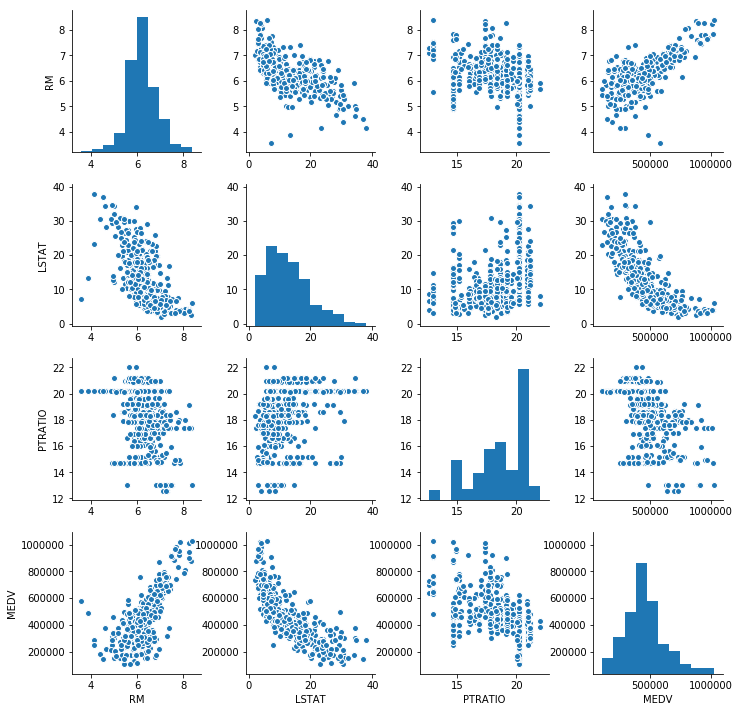

In [3]:
# Visualize the relations between the variables and their distributions
sns.pairplot(data)

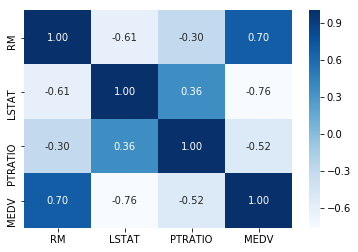

In [4]:
# Correlations between the
sns.heatmap(data.corr(), cmap='Blues', annot=True, fmt='.2f')

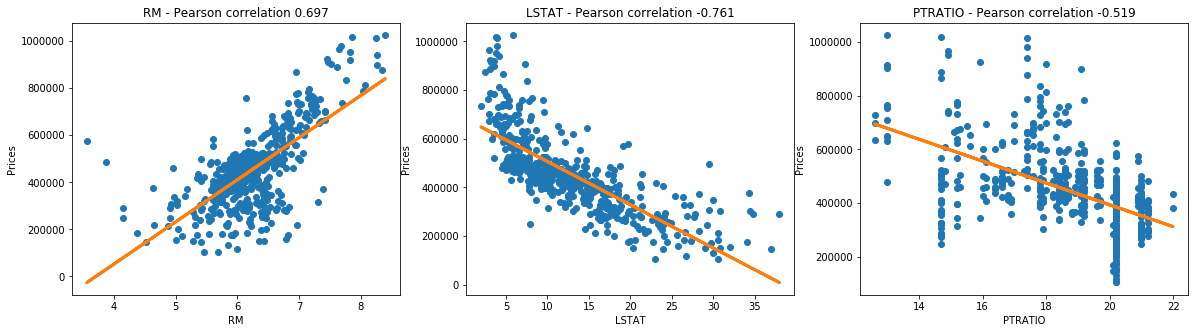

In [5]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], prices, 'o')
    fit = np.polyfit(data[col], prices, 1)
    plt.plot(data[col], data[col] * fit[0] + fit[1], lw=3)
    plt.title(col + ' - Pearson correlation ' + str(np.round(np.corrcoef(data[col], prices)[1][0], 3)))
    plt.xlabel(col)
    plt.ylabel('Prices')

### 2.2. Question 1: Feature Observation

Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? 

**Answer: **

First I would breakdown the problem into the following questions:
* Would you expect a home that has an `'RM'` value (number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?
* Would you expect a neighborhood that has an `'LSTAT'` value (percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?
* Would you expect a neighborhood that has an `'PTRATIO'` value (ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

Then, my answers would be:
* I would expect the larger the RM value (higher number of rooms), the more expensive is the price, because the home is larger. The chart of RM vs. MEDV shows this relation and the correlation of 0.7- also confirms that.
* I would expect that the lower the LSTAT (lower percentage of lower class workers), the lower is the price, because the purchasing power of the residents is low. The chart of LSTAT vs. MEDV shows this relation and the correlation of -0.76 also confirms that.
* I would expect the lower the PTRATIO (higher number of teacher per students), the more expensive are the homes, as this ratio indicates a higher purchasing power of residents. The chart of PTRATIO vs. MEDV shows this relation is not very clear which is confirmed by the correlation of -0.52.

----

## 3. Developing a Model
In this second section of the project, I will develop the tools and techniques necessary for a model to make a prediction. 

Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in the predictions.

### 3.1. Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, I will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify my model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable. **A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, I will need to implement the following:
- `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [6]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2: Fit

* Would you consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [7]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


In [8]:
# Another method to calculate the performance of this model (R2)
data2 = pd.DataFrame(data=[[3.0, 2.5], [-0.5, 0.0], [2.0, 2.1], [7.0, 7.8], [4.2, 5.3]], 
                    columns=['True Value', 'Prediction'])

y_true = data2['True Value']
y_predict = data2['Prediction']

y_true_mean = np.mean(y_true)
SSres = sum(np.square(np.subtract(y_true, y_predict)))
SStot = sum(np.square(np.subtract(y_true, y_true_mean)))
score = 1.0 - SSres/SStot
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


**Answer:**
* Yes, I do believe this model to have successfully captured, because 92.3% of the variance in target variable is predictable from the independent variable. This model roughly meets some of the criterea described below as the True Value vs. Prediction chart shows a linear relation between both variables.

### Residual Analysis:

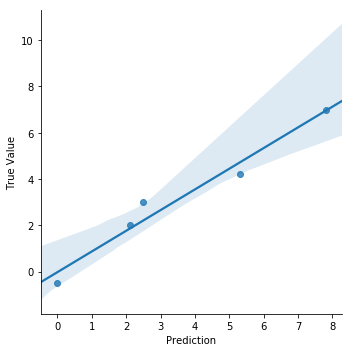

In [9]:
sns.lmplot(data=data2, x='Prediction', y='True Value')

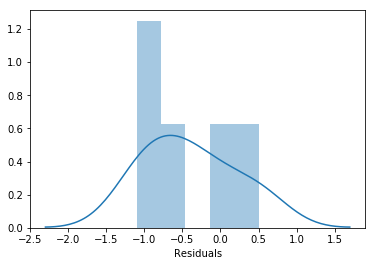

In [10]:
data2['Residuals'] = data2['True Value'] - data2['Prediction']
sns.distplot(data2['Residuals'], bins=5)

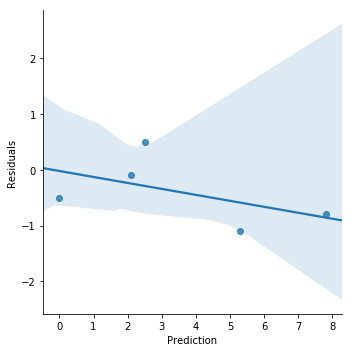

In [11]:
sns.lmplot(data=data2, x='Prediction', y='Residuals')

**Residuals:**
    
* Residuals can be thought of as elements of variation unexplained by the fitted model. Since this is a form of error, the same general assumptions apply to the group of residuals that we typically use for errors in general: _one expects them to be (roughly) normal and (approximately) independently distributed with a mean of 0 and some constant variance._
* The model should predict values higher than actual and lower than actual with equal probability.
* The level of the error should be independent of when the observation occurred in the study, or the size of the observation being predicted, or even the factor settings involved in making the prediction.
* The overall pattern of the residuals should be similar to the bell-shaped pattern observed when plotting a histogram of normally distributed data.

### 3.2. Implementation: Shuffle and Split Data
My next implementation requires that I take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, I will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of my choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [12]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Question 3: Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

**Answer: **
* The key benefits to splitting a dataset into training and testing subsets are:
 * Assess the performance of the model on an independent dataset which is the testing subset. That is, by splitting the data, the model learns from the learning subset and evaluate its effectiveness on unseen data (testing subset) which is different from the learning subset. Mixing those two datasets would be a methodological error.
 * Also prevents overfitting.

----

## 4. Analyzing Model Performance
In this third section of the project, I'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, I'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing my model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### 4.1. Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

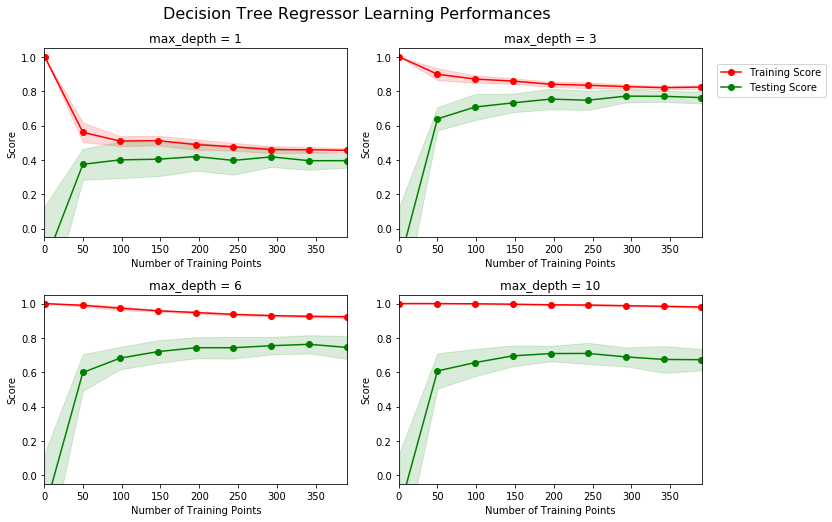

In [13]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4: Learning the Data
* Choose one of the graphs above and state the maximum depth for the model. 
* What happens to the score of the training curve as more training points are added? What about the testing curve? 
* Would having more training points benefit the model? 

**Answer: ** For model which has max depth of 3:
* If more points are added, the Training Score will decrease and will convert to a number a little higher than 0.8. On the other hand, Testing Score will increase and will convert to a number a little lower than 0.8.
* The chart indicates that having more data points will not increase scores and therefore we can conclude that they will not significantly benefit the model.
* Because a sufficiently powerful machine learning algorithm (together with nicely separable data), will have no problem correctly classifying a small number of data points
* It seems that the algorithm used in this model is powerful and have no problem correctly classifying a small number of data points (training points). For low Number of Training Points, Training Score is high. But this comes with a a cost: overfitting. This issue leads to a low overall performance of the model (Testing Score). As the Number of Training Points increases, Training Score decreases and Testing Score increases and therefore the model moves away from overfitting.

### 4.2. Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

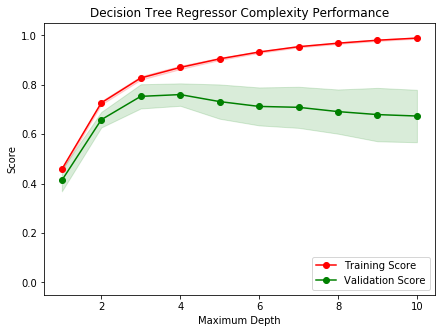

In [14]:
vs.ModelComplexity(X_train, y_train)

### Question 5: Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?

**Answer: **
* The model with max depth of 1 suffers from high bias, as both Training and Validation Scores are low and they are close to each other. Also note that it has low variance since the scores are close together. This model is not complex enough to learn the structure of the data.
* On the other hand, the model with max depth of 10 suffer from high variance as Training and Validation Scores are far away from each other. The model is basically just memorizing our training data and will not generalize well to new unseen data.

### Question 6: Best-Guess Optimal Model
* Which maximum depth do you think results in a model that best generalizes to unseen data? 
* What intuition lead you to this answer?

**Answer: **
* I believe it would the the graph with max depth of 3, because the scores seems fair (around 0.8) and when max depth starts increasing from there, the more complex is the model and more distant each score gets to each other. Simpler model that leads to similar results of more complex ones should be the one selected as stated by the principle of logic: Occam's razor.

-----

## 5. Evaluating Model Performance
In this final section of the project, I will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7: Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

**Answer: **

* Grid Search is a technique of exaustive search through a manually specified subset of hyper-parameters that aims to find the optimal values of hyper-parameters that leads to the optimal model. When you have to evaluate more than one hyper-parameters, the number of possibilities increases very fast, therefore assessing them manually is not feasible and Grid Search can be the solution.
* A Grid Search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.
* In the example discussed previoulsy, we are evaluating maximum depth which is an hyper-parameter of the model. In this case, Grid Search would seek the best value of maximum depth (hyper-parameters) that would lead to a model with best scores: both Training and Testing. This is achieved by creating models with manually specified values of the hyper-parameter (max depth) and calculating score for each model. Then the model with the best score is selected and therefore it is known the optimal value of the hyper-parameter.
* Grid Search can help us avoiding Overfitting and Underfitting.

### Question 8: Cross-Validation

* What is the k-fold cross-validation training technique? 
* What benefit does this technique provide for grid search when optimizing a model?

**Answer: **
* When evaluating different hyperparameters, there is still a **risk of overfitting on the test set** because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.
* However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.
* A solution to this problem is a procedure called cross-validation. Cross-validation also allows us to maximize the training phase by randomly generating train/test splits multiple times from the same data set and to assess how the results will generalize to an independent data set.
* In basic approach, called **k-fold CV**, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
 * A model is trained using k-1 of the folds as training data;
 * The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
* The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.
* ** In summary, k-fold  cross validation mitigates the risk of overfitting on the test set when grid search is optmizing a model by creating k folds of training, validation and testing sets. The model learns from the training set, calculates the scores on the validation set and use the testing set to make sure the model is working properly. **

### 5.1. Implementation: Fitting a Model
My final implementation requires that I bring everything together and train a model using the **decision tree algorithm**. To ensure that I am producing an optimized model, I will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, I will find my implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique I describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While I'm working on my implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, I will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [15]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': list(range(1,11))}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### 5.2. Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. I can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9: Optimal Model

* What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [16]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


In [17]:
# Performance of Optimal Model (Max Depth = 4):
print("Performance of Model with 'max_depth' of 4: %.2f" % performance_metric(y_test, reg.predict(X_test)))

Performance of Model with 'max_depth' of 4: 0.84


In [ ]:
# Train the Model with Max Depth = 3
reg2 = DecisionTreeRegressor(max_depth=3)
reg2.fit(X_train, y_train)

# Performance of Optimal Model (Max Depth = 3):
print("Performance of Model with 'max_depth' of 3: %.2f" % performance_metric(y_test, reg2.predict(X_test)))

Performance of Model with 'max_depth' of 3: 0.77


In [ ]:
# In order to have a more robust estimate of the best max_depth parameter, 
# I might want to run the grid search algorithm multiple times.
max_depths = []
for i in range(500):
    reg = fit_model(X_train, y_train)
    max_depths.append(reg.get_params()['max_depth'])
best_max_depth = np.mean(max_depths)
print("The Best model, on average, has a max depth of:", best_max_depth)

**Answer: ** According to Grid Search the optimal maximum depth is 4 which is larger than my guess in Question 6 of max depth of 3. The performance calculations show that the model with max depth of 4 performs better than the one with 3.

### Question 10: Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

In [ ]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

**Answer: **
* Predicted selling price for Client 1's home: \$403,025.00
* Predicted selling price for Client 2's home: \$237,478.72
* Predicted selling price for Client 3's home: \$931,636.36


* The prices seams reasonable. As previoulsy analyzed:
 * The higher the Total Number of Rooms in Home, the higher the Selling Price (correlation between two variables is 0.70).
 * The lower the Neighborhood Poverty Level, the higher the Selling Price (correlation -0.76).
 * The lower the Student-teacher Ratio of Nearby Schools, the higher the Selling Price (correlation 0.52).
* Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level. The Selling Price should be the higher among the three clients which is exactly what the model tells us.
* While client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools. The Selling Price should be the lowest among the three clients which is exactly what the model tells us.
* Client 1's prediction is reasonable because as this house has 3 attributes that makes it more expensive than Client 2's:
 * Client 1's house has less room than Client's 2
 * Client 1's house is located in a neighorhood with lower povery level than Client's 2
 * Client 1's house is located in a neighorhood with better Student-teacher ratio than Client's 2
* Similar analysis could be done comparing Client 1's house with Client 3's and the conclusion would be that Client 1's house is less expensive than Client 3's.
Using both comparisons, Client 1's house has a price which is lower Client 3's and higher than Client 2's which is actually what the models predicts.
* The histogram below presents the comparison of the 3 prices. 

In [ ]:
# Histogram  presents the comparison of the 3 prices
for i,price in enumerate(reg.predict(client_data)):
    plt.hist(prices, bins = 30)
    plt.axvline(price, lw = 3)
    plt.text(price-50000, 50, 'Client '+str(i+1), rotation=90)

### 5.3. Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

I will run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.

In [ ]:
sensivity = vs.PredictTrials(features, prices, fit_model, client_data)

### Question 11: Applicability

* In a few sentences, let's discuss whether the constructed model should or should not be used in a real-world setting.  

I will first take a look at the range in prices as calculated in the code snippet above and then I will be answering some of this questions:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of appliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?


**Answer: **
* The constructed model **should not** be used in a real-word setting ** in 2017**. Here are some facts that support this affirmation:
 * Market inflation plays a critical role in adjusting the home prices. It is not clear whether the prices were adjusted to Boston's market inflation or USA's. The values of other variables (Students to Professor ratio and Poverty Rate) should be updated as well.
 * There are other key factors that should be considered as age, area, conservation state, appliances of the home, wheter the home is a house or an apartment, whether the home is in urban or rural area.
 * It is not fair to estimate a price of a home based on the characteristics of the entire neighborhood. It will not take into account the specifics of each house and each house will be priced based on the averageprice of the houses in the neighborhood.
 * The Sensivity Analysis presents that predictions of home prices has significant variations, based on how the model was trained. Thus the model provides a range of prices instead of an accurate one.